In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from zipfile import ZipFile
import pandas as pd
import torch
import random
import numpy as np
from matplotlib import pyplot as plt

from HP import PointProcessStorage, DirichletMixtureModel, EM_clustering

In [3]:
def load_data(path, maxlen=-1):
    s = []
    classes = set()
    for i in range(1, 300):
        path_ = Path(path, f'{i}.txt')
        with path_.open('r') as f:
            df = pd.read_csv(f)
        classes = classes.union(set(df['event'].unique()))
        df['time'] = pd.to_datetime(df['time'])
        df['time'] = (df['time'] - df['time'][0]) / np.timedelta64(1,'D')
        if maxlen > 0:
            df = df.iloc[:maxlen]
        df = df.drop(['id', 'option1'], axis=1)
        s.append(df)

    classes = list(classes)
    class2idx = {clas: idx for idx, clas in enumerate(classes)}

    ss, Ts = [], []
    for i, df in enumerate(s):
        if s[i]['time'].to_numpy()[-1] < 0:
            continue
        s[i]['event'].replace(class2idx, inplace=True)
        tens = torch.FloatTensor(np.vstack([s[i]['time'].to_numpy(), s[i]['event'].to_numpy()])).T
        if maxlen > 0:
            tens = tens[:maxlen]
        ss.append(tens)
        Ts.append(tens[-1, 0])

    Ts = torch.FloatTensor(Ts)

    return ss, Ts, class2idx

In [4]:
path = Path('../..', 'data', 'IPTV_Data')
ss, Ts, class2idx = load_data(path, maxlen=200)
#ss = ss[:100] 

In [5]:
D = 1
basis_fs = [lambda x: 0.1 * torch.exp(- x**2 / 2*k ) for k in range(D)]

In [6]:
hp = PointProcessStorage(ss, Ts, basis_fs)

In [7]:
C = len(class2idx)
K = 5
Sigma = (torch.eye(C, C) + torch.rand(C, C)).unsqueeze(-1).unsqueeze(-1).repeat(1,1, D, K)
B = torch.ones(C, K)
alpha = 1.

In [8]:
model = DirichletMixtureModel(K, C, D, alpha, B, Sigma)

In [9]:
EM = EM_clustering(hp, model)

In [10]:
r = EM.e_step()

In [18]:
print(f'Initial NLL: {EM.hp_nll(r, model.mu, model.A).item() / len(ss)}')

Initial NLL: -11.644026638273411


In [12]:
r, nll_history = EM.learn_hp(niter=5)

100%|██████████| 5/5 [03:00<00:00, 36.10s/it]


Text(0, 0.5, 'NLL')

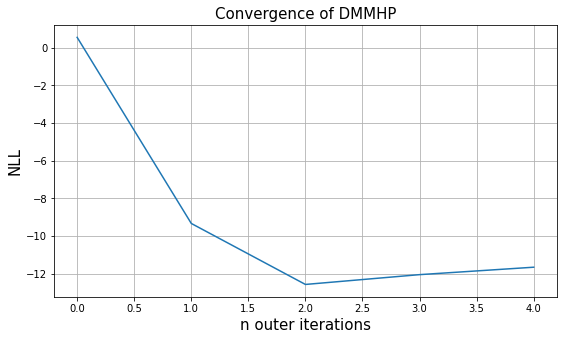

In [15]:
plt.figure(figsize=(9, 5))
plt.grid()
plt.plot(np.arange(len(nll_history)), np.array(nll_history) / len(ss))
plt.title('Convergence of DMMHP', fontsize=15)
plt.xlabel('n outer iterations', fontsize=15)
plt.ylabel('NLL', fontsize=15)

In [16]:
assert (model.A >= 0).all()

In [17]:
r.argmax(-1)

tensor([3, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 3, 3, 2, 2, 2, 0, 2, 0, 4, 0, 1, 2,
        2, 4, 4, 2, 4, 1, 2, 4, 2, 3, 2, 1, 4, 4, 1, 4, 4, 0, 4, 0, 2, 2, 4, 4,
        0, 4, 2, 4, 0, 0, 2, 4, 4, 4, 4, 3, 2, 2, 2, 3, 2, 3, 2, 4, 2, 1, 2, 2,
        2, 0, 4, 2, 2, 3, 2, 2, 2, 4, 0, 4, 3, 2, 1, 4, 2, 2, 1, 2, 2, 4, 2, 3,
        2, 4, 2, 0, 0, 4, 2, 2, 2, 2, 2, 4, 4, 0, 2, 4, 3, 4, 0, 4, 2, 0, 0, 0,
        4, 1, 0, 2, 4, 2, 2, 3, 0, 4, 0, 2, 2, 4, 0, 2, 0, 2, 2, 0, 3, 4, 2, 0,
        4, 3, 3, 2, 2, 2, 2, 2, 1, 4, 0, 1, 3, 3, 0, 2, 2, 3, 2, 2, 4, 4, 2, 2,
        2, 2, 1, 4, 3, 4, 0, 2, 3, 2, 2, 0, 4, 4, 2, 2, 2, 2, 4, 4, 4, 2, 2, 4,
        3, 3, 1, 4, 2, 2, 2, 2, 4, 4, 4, 2, 2, 4, 2, 2, 2, 4, 2, 2, 4, 2, 2, 2,
        4, 2, 0, 3, 2, 4, 4, 0, 4, 1, 0, 0, 0, 2, 2, 0, 4, 2, 0, 2, 0, 2, 2, 2,
        4, 4, 3, 2, 0, 4, 4, 0, 4, 2, 4, 3, 2, 4, 2, 2, 2, 2, 4, 3, 0, 4, 2, 4,
        0, 2, 4, 3, 4, 1, 0, 1, 1, 4, 2, 2, 4, 4, 2, 0, 4, 4, 1, 2, 4, 4, 0, 3,
        3, 1, 1, 2, 2, 2, 0, 0, 2, 3, 3]